In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
#os.chdir(os.path.expanduser('../../'))
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pickle as pkl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
matplotlib.rcParams.update({'font.size': 20})

INFO: Using pytorch backend


In [19]:
GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "GTs/moons_FIF/checkpoints/last.ckpt"
    )

model_src = "lightning_logs/2m_dnf_b1_4n_lr1_long/version_0"
model = fff.FreeFormFlow.load_from_checkpoint(
    f"{model_src}/checkpoints/last.ckpt"
)

2moons
cond_dim:  0
latent_dim:  1
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
add fixed noise
fff.model 2
[2, 128, 256, 25]
[2, 128, 256, 25]
[2, 256, 256, 25]
[2, 256, 256, 25]
[2, 256, 256, 25]
[2, 256, 256, 25]
(1,) 2
[2, 128, 256, 25]
(1,) 2
[2, 256, 256, 25]
(1,) 2
[2, 256, 256, 25]
2moons
cond_dim:  0
latent_dim:  1
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]
[2, 512, 512, 2]


/export/home/wjoran/miniconda3/envs/py11/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.2.0


In [27]:
torch.set_grad_enabled(False)

60000


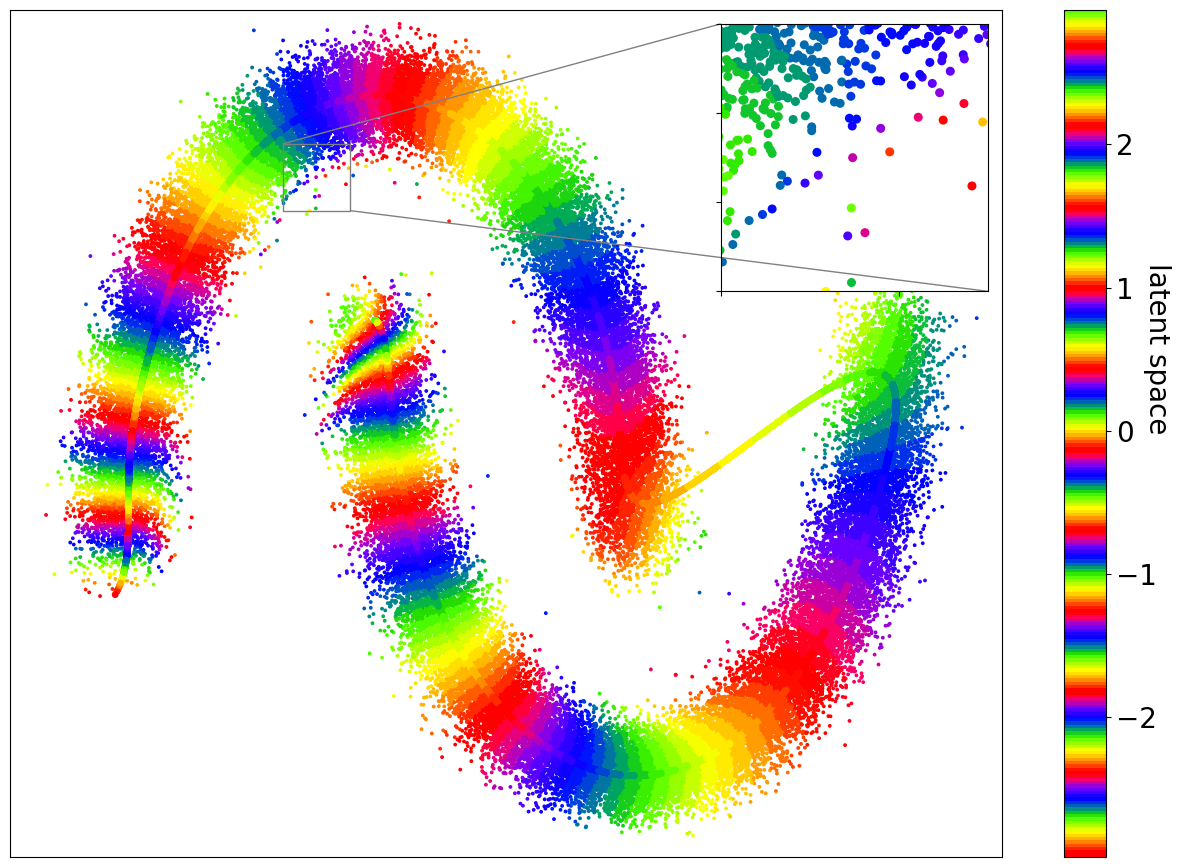

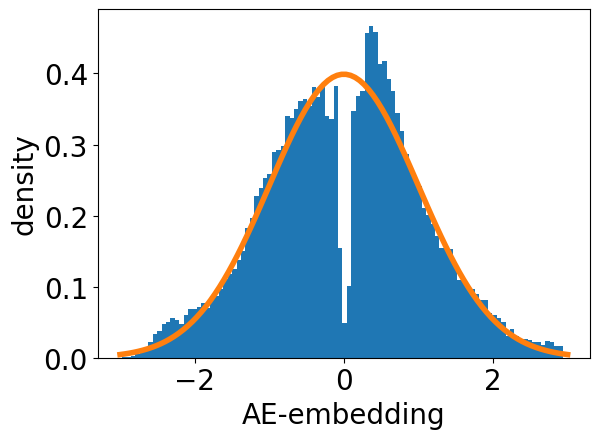

In [196]:
c_targets = plot_manifold(GT.eval())

In [195]:
from fff.evaluate.plots import all_conditions
def plot_manifold(rectangular_flow, condition=None):
    eps = 1e-12
    fig, ax = plt.subplots(figsize=[16,11])
    data = {}

    train_batch = rectangular_flow.train_data[:]
    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c = conditioned.condition
    c_empt = torch.empty((c.shape[0], 0), dtype=c.dtype)
    device = rectangular_flow.device
    #print(train_samples.shape)

    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_empt.split(batch_size))
    ])    
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c_empt.split(batch_size))
    ])
    print(z_train.shape[0])

    """
    #print(z_train.shape)
    t = torch.randint(0, 1000, (z_train.size(0),), device=device).long()
    z_diff, epsilon = rectangular_flow.diffuse(z_train.to(device), t, rectangular_flow.alphas_.to(device))
    """
    
    #z_test = torch.randn_like(z_train)
    #x1_test = rectangular_flow.sample((2048,), c[:2048].to(device)).cpu()
    #print(c.shape)

    sc = ax.scatter(*train_samples.T, s=3, label="Original", c=z_train.numpy(), cmap='prism')
    ax.scatter(*x1_train.cpu().T, s=15, label="Reconstruction", c=z_train.numpy(), cmap='prism')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.axis('equal')

    axins = zoomed_inset_axes(ax, 4, loc=1) # zoom = 6
    axins.scatter(*train_samples.T, s=30, label="Original", c=z_train.numpy(), cmap='prism')
    
    # sub region of the original image
    x1, x2, y1, y2 = -1., -0.7, 1., 1.3
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    
    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    cbar = fig.colorbar(sc)
    cbar.set_label('latent space', rotation=270, labelpad=10, y=0.6)
    path = f"plots/2m/GT/Mapping.png"
    Path(f"plots/2m/GT").mkdir(parents=True, exist_ok=True)
    ax.set_xlim(-2.15, 2.15)
    ax.set_ylim(-1.9, 1.9)
    #plt.savefig(path, bbox_inches='tight')
    #plt.scatter(*x1_test.T, s=2, label="Samples")
    #print(x1_test[0])

    plt.show()
    plt.close()

    
    
    a = np.linspace(-3,3,100)
    plt.hist(z_train.squeeze(), bins=100, density=True)
    plt.plot(a, normal(a), linewidth=4)
    plt.xlabel("AE-embedding")
    plt.ylabel("density")
    plt.tight_layout()
    path = f"plots/2m/GT/LD.png"
    #plt.savefig(path, bbox_inches='tight')
    """
    betas = rectangular_flow.alphas_
    plt.plot(torch.linspace(1,1000,1000), betas)
    plt.show()
    print(*z_train.T)

    plt.hist(betas[t.cpu()])
    plt.show()
    time_embedding = torch.nn.Embedding(1000, 8)
    t = torch.arange(1,1000, step=10)
    plt.plot(t, time_embedding(t)[:,:])
    """

In [22]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [27]:
save = True
plot_dir = "2m/dnf_final"
model_name = "DNF"
from pathlib import Path
import shutil
if save:
    Path(f"plots/{plot_dir}/runfile").mkdir(parents=True, exist_ok=True)
    shutil.copytree(model_src, f"plots/{plot_dir}/runfile", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)

processing data...
inn
sampling fibers...
nan
nan
nan
0.07633066177368164
nan
nan
nan
0.021862387657165527
nan
nan
nan
nan
0.03145705163478851
0.043103985488414764
0.025928683578968048
nan
nan
0.008953511714935303
0.008703112602233887
nan
nan
nan
nan
nan
nan
nan
nan


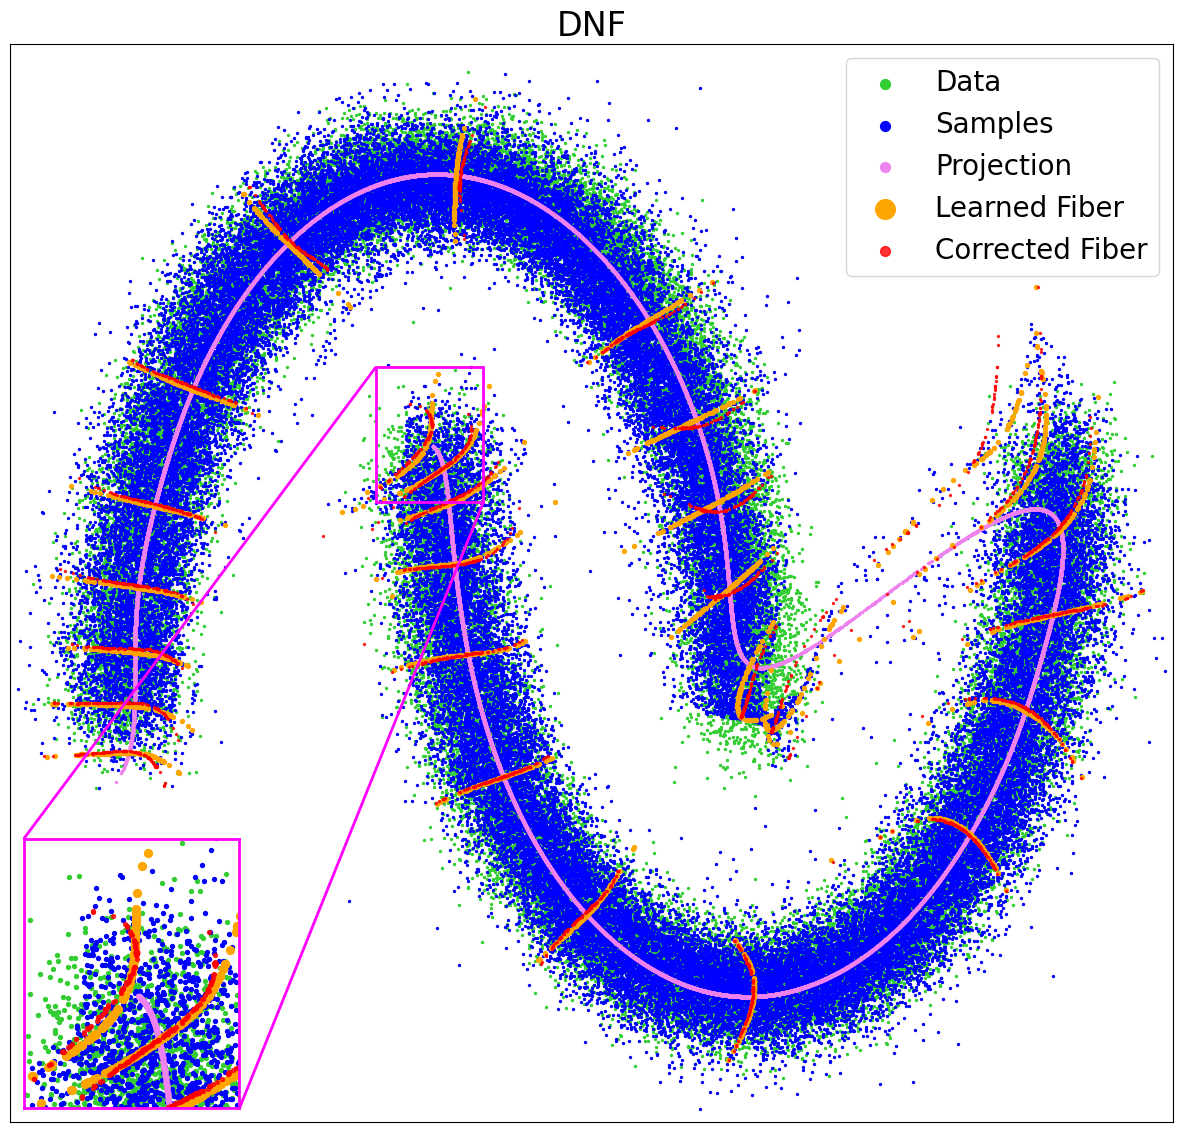

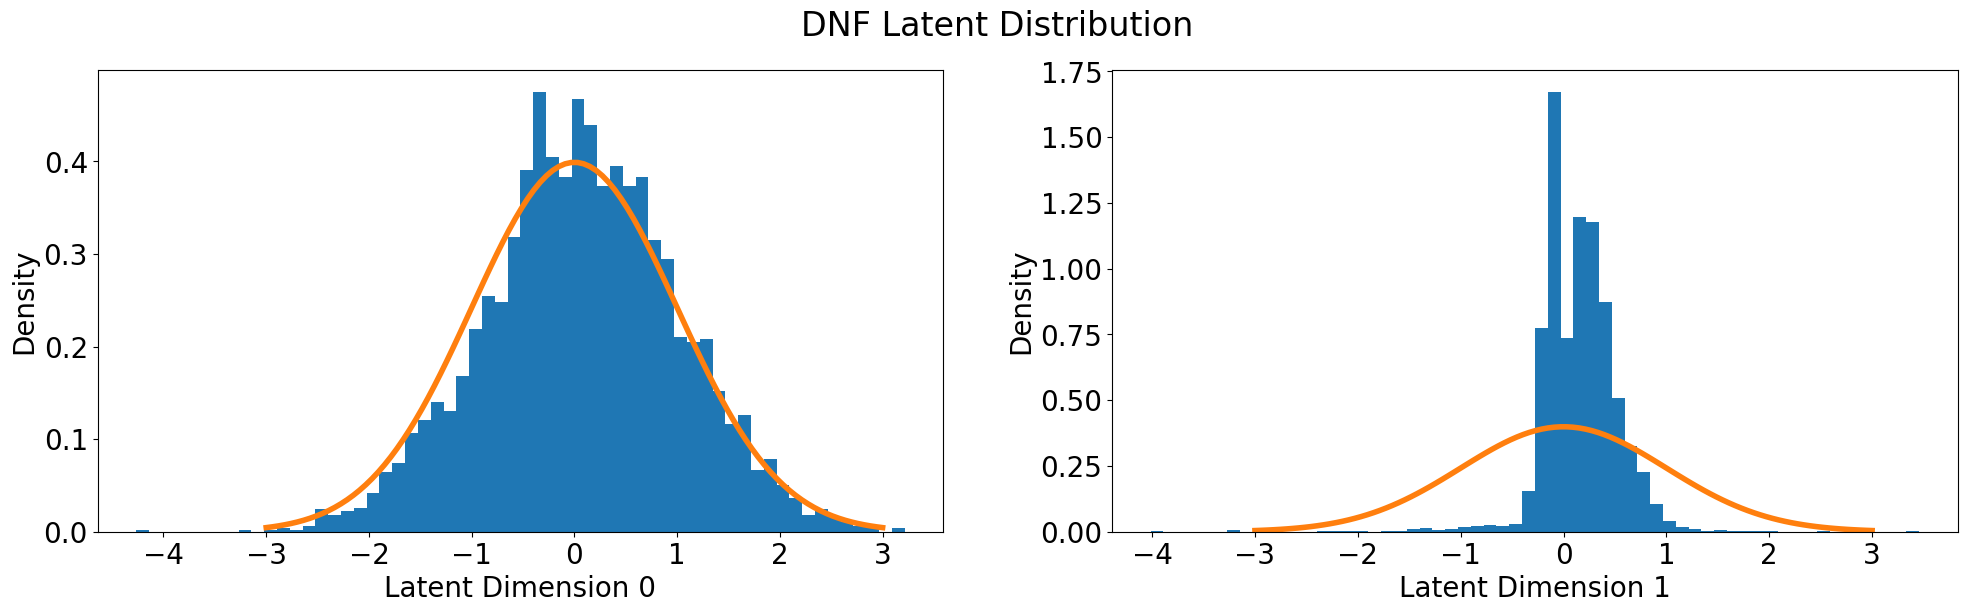

In [28]:
c_targets = plot_GT(model, data_type="train", gd_steps=500, N_fibers=27)

In [25]:
@torch.no_grad()
def calc_fibl(model, data_type='test'):
    device = GT.device

    if data_type=='train':
        data = GT.train_data[:]
    elif data_type=='val':
        data = GT.val_data[:]
    elif data_type=='test':
        data = GT.test_data[:]

    conditioned = GT.apply_conditions(data)
    samples = conditioned.x_noisy
    c_GT = conditioned.condition
    
    plt_samples = samples.T.numpy()
    
    print("processing data...")
    batch_size = GT.hparams.batch_size
    z_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(samples.split(batch_size), c_GT.split(batch_size))
    ])
    
    #reconstruct data with model
    n_r = 40
    model.to(device)
    print(z_GT.shape)
    z_orig = z_GT.repeat(n_r,1)
    c_m = ((z_orig - model.data_shift) / model.data_scale)
    
    print(model.transform)
    fibers = model.sample(torch.Size([c_m.shape[0]]), c_m.to(device)).cpu()
    z_check = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(fibers.split(batch_size), c_GT.repeat(n_r,1).split(batch_size))
    ])
    print(z_check.shape)
    z_orig = z_orig[z_check.isfinite()].squeeze()
    z_check = z_check[z_check.isfinite()]
    print(z_check.shape)
    print(z_orig.shape)

    fiber_check = torch.sqrt(torch.sum((z_orig - z_check).reshape(z_orig.shape[0],-1) ** 2, -1))
    fib_var, fiber_loss = torch.var_mean(fiber_check, dim=0)
    print("with outliers: mean=", fiber_loss.item(), ", std=", torch.sqrt(fib_var).item())
    topk_values, _ = torch.topk(fiber_check, fiber_check.shape[0]//1000)
    fiber_check_filtered = fiber_check[fiber_check<topk_values.min()]
    fibf_var, fiberf_loss = torch.var_mean(fiber_check_filtered, dim=0)
    print("without outliers: mean=", fiberf_loss.item(), ", std=", torch.sqrt(fibf_var).item())

    teacher_normal = torch.distributions.normal.Normal(torch.Tensor([0]), torch.eye(1))
    fiber_check_cum = torch.squeeze(torch.abs(teacher_normal.cdf(z_orig) - teacher_normal.cdf(z_check)))
    print(fiber_check_cum.shape)
    fib_var_cum, fiber_loss_cum = torch.var_mean(fiber_check_cum, dim=0)
    print("cdf: mean=", fiber_loss_cum.item(), ", std=", torch.sqrt(fib_var_cum).item())
    topk_values, _ = torch.topk(fiber_check_cum, fiber_check_cum.shape[0]//1000)
    fiber_check_filtered_cum = fiber_check_cum[fiber_check_cum<topk_values.min()]
    fibf_var_cum, fiberf_loss_cum = torch.var_mean(fiber_check_filtered_cum, dim=0)
    print("cdf without outliers: mean=", fiberf_loss_cum.item(), ", std=", torch.sqrt(fibf_var_cum).item())

In [26]:
calc_fibl(model)

processing data...
torch.Size([5000, 1])
inn
torch.Size([200000, 1])
torch.Size([200000])
torch.Size([200000])
with outliers: mean= 0.008233727887272835 , std= 0.0496508926153183
without outliers: mean= 0.006951407995074987 , std= 0.01975102908909321
torch.Size([200000])
cdf: mean= 0.002046973677352071 , std= 0.014232235960662365
cdf without outliers: mean= 0.0016600749222561717 , std= 0.005097670014947653


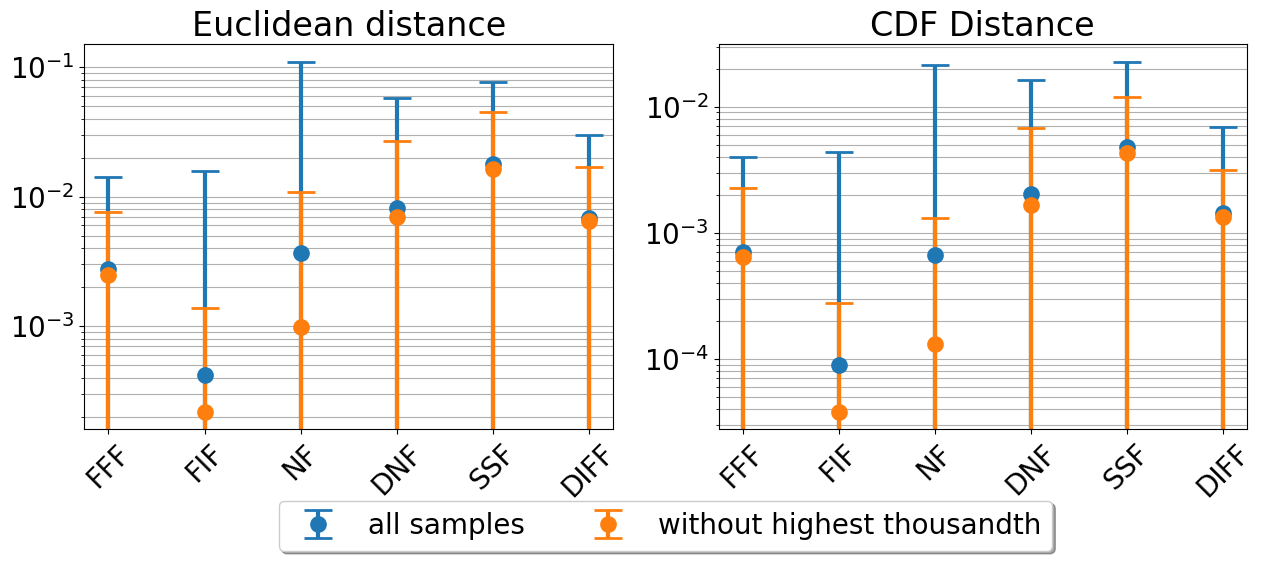

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True,figsize=[15,5])
names = ["FFF", "FIF", "NF", "DNF", "SSF", "DIFF"]

eu_means = [0.00275, 0.000422762, 0.00369081, 0.0082337, 0.0177932288, 0.0068926624]
eu_stds = [0.0113753, 0.01528502, 0.106195, 0.04965089, 0.059396039, 0.02299189381]
eu_means_f = [0.0025054828, 0.00021974, 0.0009960713, 0.006951407, 0.016250129, 0.006453854]
eu_stds_f = [0.0050916820, 0.00116214, 0.009929576, 0.019751029, 0.028977705, 0.010344727]

cdf_means = [0.0007044, 8.956018427852541e-05, 0.0006680744, 0.0020469736, 0.00475747, 0.00142898911]
cdf_stds = [0.0033156, 0.0042803, 0.0205672699, 0.01423223, 0.0180091, 0.00549410423]
cdf_means_f = [0.00063973, 3.816442404058762e-05, 0.0001322572, 0.001660074922, 0.00427030, 0.0013306038]
cdf_stds_f = [0.001628, 0.00024096, 0.001181435, 0.00509767, 0.00770989432, 0.00182940228]
x1 = [0,1,2,3,4,5]

ax1.set_xticks(x1)
ax1.set_xticklabels(names[:], minor=False, rotation=45)
ax1.errorbar(x1, eu_means, eu_stds, fmt='o', capsize=10, markersize=10, elinewidth=3, markeredgewidth=2, label="all samples")
ax1.errorbar(x1, eu_means_f, eu_stds_f, fmt='o', capsize=10, markersize=10, elinewidth=3, markeredgewidth=2, label="without highest thousandth")
ax1.set_yscale('log')
ax1.grid(True, which="both", ls="-", axis="y")
ax1.set_title("Euclidean distance")

#ax2.yaxis.tick_right()
ax2.set_xticks(x1)
ax2.set_xticklabels(names[:], minor=False, rotation=45)
ax2.errorbar(x1, cdf_means, cdf_stds, fmt='o', capsize=10, markersize=10, elinewidth=3, markeredgewidth=2)
ax2.errorbar(x1, cdf_means_f, cdf_stds_f, fmt='o', capsize=10, markersize=10, elinewidth=3, markeredgewidth=2)
ax2.set_yscale('log')
ax2.grid(True, which="both", ls="-", axis="y")
ax2.set_title("CDF Distance")
ax1.legend(loc='upper center', bbox_to_anchor=(1.1, -0.15),
          ncol=3, fancybox=True, shadow=True)


path = f"plots/2m/fiber_dist.png"
plt.savefig(path, bbox_inches='tight')

In [23]:
from fff.evaluate.plots import all_conditions

@torch.no_grad()
def plot_GT(model, data_type='train', gd_steps=50, N_fibers=21):
    device = GT.device
    fig, ax = plt.subplots(figsize=[15,14])
    data = {}

    if data_type=='train':
        data = GT.train_data[:]
    elif data_type=='val':
        data = GT.val_data[:]
    elif data_type=='test':
        data = GT.test_data[:]

    conditioned = GT.apply_conditions(data)
    samples = conditioned.x_noisy
    c_GT = conditioned.condition
    
    #plot samples
    plt_samples = samples.T.numpy()
    #col_sam = "green" if model.transform == "diffusion" else "limegreen"
    ax.scatter(*plt_samples, s=2, label=r"Data", c="limegreen" ,alpha=1)

    
    print("processing data...")
    batch_size = GT.hparams.batch_size
    z_GT = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(samples.split(batch_size), c_GT.split(batch_size))
    ])
    #GT-model decodes data
    x1 = torch.cat([
        GT.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_GT.split(batch_size), c_GT.split(batch_size))
    ])   
    
    #reconstruct data with model
    model.to(device)
    c_m = (z_GT - model.data_shift) / model.data_scale
    print(model.transform)
    if model.transform != "diffusion":
        z_m = torch.cat([
            model.encode(batch.to(device), c_batch.to(device)).cpu()
            for batch, c_batch in zip(samples.split(batch_size), c_m.split(batch_size))
        ])
        if model.transform=="inn":
            z_list = []
            for batch, c_batch in zip(z_m.split(batch_size), c_m.split(batch_size)):
                _z_dense = model.transform_model.encode(batch.to(device), c_batch.to(device))
                while True:    
                    if isinstance(_z_dense, tuple):
                        _z_dense = _z_dense[0]
                    else: break
                z_list.append(_z_dense.detach().cpu())
            z_dense_m = torch.cat(z_list)
        elif model.transform:
            z_dense_m = torch.cat([
                model.transform_model.encode(batch.to(device), c_batch.to(device)).cpu()
                for batch, c_batch in zip(z_m.split(batch_size), c_m.split(batch_size))
            ])
        else:
            z_dense_m = z_m
    if model.transform not in ["diffusion", "inn"]:
        if model.transform:
            z1_m = torch.cat([
                model.transform_model.decode(batch.to(device), c_batch.to(device)).cpu()
                for batch, c_batch in zip(z_dense_m.split(batch_size), c_m.split(batch_size))
            ])
        else:
            z1_m = z_m
        x_m1 = torch.cat([
            model.decode(batch.to(device), c_batch.to(device)).cpu()
            for batch, c_batch in zip(z1_m.split(batch_size), c_m.split(batch_size))
        ])
    else:
         x_m1 = model.sample(torch.Size([x1.shape[0]]), c_m.to(device)).cpu()
                
    
    recon = x_m1.cpu().T.numpy()
    #plot reconstruction
    label_rec = "Samples" if model.transform in ["diffusion","inn"] else "Reconstruction"
    ax.scatter(*recon, s=2, label=label_rec, c='b',alpha=1)
    """
    lines_x = np.array([samples[0,:],recon[0,:]])
    lines_y = np.array([samples[1,:],recon[1,:]])
    plt.plot(lines_x, lines_y, linewidth=0.4, color='red', alpha=1)
    """        
    #plot decoded data
    ax.scatter(*x1.T, s=2, label=r"Projection", c="violet")
    
    print("sampling fibers...")
    fiber_size = 100
    step = np.concatenate((np.linspace(-2.8,-0.4,N_fibers//3),np.linspace(-0.3,0.3,N_fibers//3),np.linspace(0.4,2.8,N_fibers//3)))
    c = []
    fibers_true = []
    for i in range(N_fibers):
        c.append(((torch.ones([fiber_size,1]) * step[i]) - model.data_shift) / model.data_scale)
    c = torch.cat(c)
    fibers_learned = model.sample(torch.Size([N_fibers*fiber_size]), c.to(device)).cpu()
    #correct fibers
    for i in range(N_fibers):
        x_c, _ = calc_PGD(fibers_learned[i*fiber_size:(i+1)*fiber_size], c[i*fiber_size:(i+1)*fiber_size], gd_steps)
        fibers_true.append(x_c)
    fibers_true = torch.cat(fibers_true)
    #plot both fibers
    ax.scatter(*fibers_learned.T, s=8, color = "orange", label="Learned Fiber")
    ax.scatter(*fibers_true.T, s=2, color = "red", label="Corrected Fiber",alpha=0.8)
    
    ax.axis('equal')
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

    axins = zoomed_inset_axes(ax, 2, loc="lower left") # zoom = 6
    axins.spines['bottom'].set_color('magenta')
    axins.spines['bottom'].set_linewidth(2.)
    axins.spines['top'].set_color('magenta')
    axins.spines['top'].set_linewidth(2.)
    axins.spines['left'].set_color('magenta')
    axins.spines['left'].set_linewidth(2.)
    axins.spines['right'].set_color('magenta')
    axins.spines['right'].set_linewidth(2.)
    axins.scatter(*plt_samples, s=8, label=r"Data", c="limegreen" ,alpha=1)
    axins.scatter(*recon, s=8, label=label_rec, c='b',alpha=1)
    axins.scatter(*x1.T, s=8, label=r"Projection", c="violet")
    axins.scatter(*fibers_learned.T, s=32, color = "orange", label="Learned Fiber")
    axins.scatter(*fibers_true.T, s=8, color = "red", label="Corrected Fiber",alpha=0.8)
    
    # sub region of the original image
    #x1, x2, y1, y2 = 1.55, 1.85, 0.25, 0.8
    x1, x2, y1, y2 = -0.8, -0.4, 0.3, 0.8
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="magenta", linewidth=2)

    #plot grid reconstruction
    if not model.transform in ["diffusion", "inn"]:
        plot_samples_grid(ax, model)
        plot_samples_grid(axins, model)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    axins.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axins.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.legend(markerscale=5., loc="upper right")
    ax.set_title(f"{model_name}")
    if save:
        path = f"plots/{plot_dir}/eval_plot.png"
        plt.savefig(path, bbox_inches='tight')
    plt.show()
    plt.close()

    
    #plot latent distribution
    if not model.transform == "diffusion":
        n_dim = z_dense_m.shape[1]
        fig, axes = plt.subplots(1, n_dim, figsize=(12*n_dim, 6))
        a = np.linspace(-3,3,100)
        for i in range(n_dim):
            if n_dim>1:
                axis = axes[i]
            else:
                axis = axes
            axis.hist(z_dense_m[:4000,i].squeeze(), bins=60, density=True)
            axis.plot(a, normal(a), linewidth=4)
            axis.set_xlabel(f'Latent Dimension {i}')
            axis.set_ylabel('Density')
        fig.suptitle(f'{model_name} Latent Distribution')
        if save:
            path = f"plots/{plot_dir}/latent.png"
            plt.savefig(path, bbox_inches='tight')

In [16]:
from fff.evaluate.plots import ensure_list, build_mesh
@torch.no_grad()

def plot_grid(ax, mapping, pos_min, pos_max, resolution=25,
              sub_resolution=0, color="black", linewidth=0.75, linestyle="-",
              pos_in_filter=None, device=None, dtype=None, **kwargs):
    for row_mode, this_resolution in zip([True, False],
                                         ensure_list(resolution, 2)):
        lines_resolution = [this_resolution,
                            this_resolution * (sub_resolution + 1)][::-1 if row_mode else 1]
        x, y, pos = build_mesh(pos_min, pos_max, lines_resolution,
                               device=device, dtype=dtype)
        if pos_in_filter is not None:
            pos[~pos_in_filter(pos)] = float("nan")
        pos_out = mapping(pos).cpu()
        pos_new = pos_out.reshape((*x.shape, -1)).numpy()
        if row_mode:
            segs = pos_new.transpose(1, 0, 2)
        else:
            segs = pos_new
        ax.plot(segs[:, :, 0], segs[:, :, 1], ls=linestyle, color=color,
                 lw=linewidth, **kwargs)

@torch.no_grad()
def plot_samples_grid(ax, model, resolution=30):
    extent = [-2, 2]
    def reconstruction(x):
        x = x.to(GT.device)
        print(x.shape)
        c_GT = GT.apply_conditions((x,)).condition
        c = (GT.encode(x, c_GT) - model.data_shift) / model.data_scale
        return model(x,c)
    
    def distance_filter(pos):
        dist = torch.min(((pos.unsqueeze(0) - model.val_data[:][0].unsqueeze(1))**2).sum(dim=2), dim=0)[0]
        return dist < 0.03
    
    plot_grid(ax, lambda x: x, *extent, color="0.7", resolution=resolution, pos_in_filter=distance_filter)
    plot_grid(ax, reconstruction, *extent, sub_resolution=50, resolution=resolution, pos_in_filter=distance_filter)

/export/home/wjoran/miniconda3/envs/py11/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([45900, 2])
torch.Size([45900, 2])


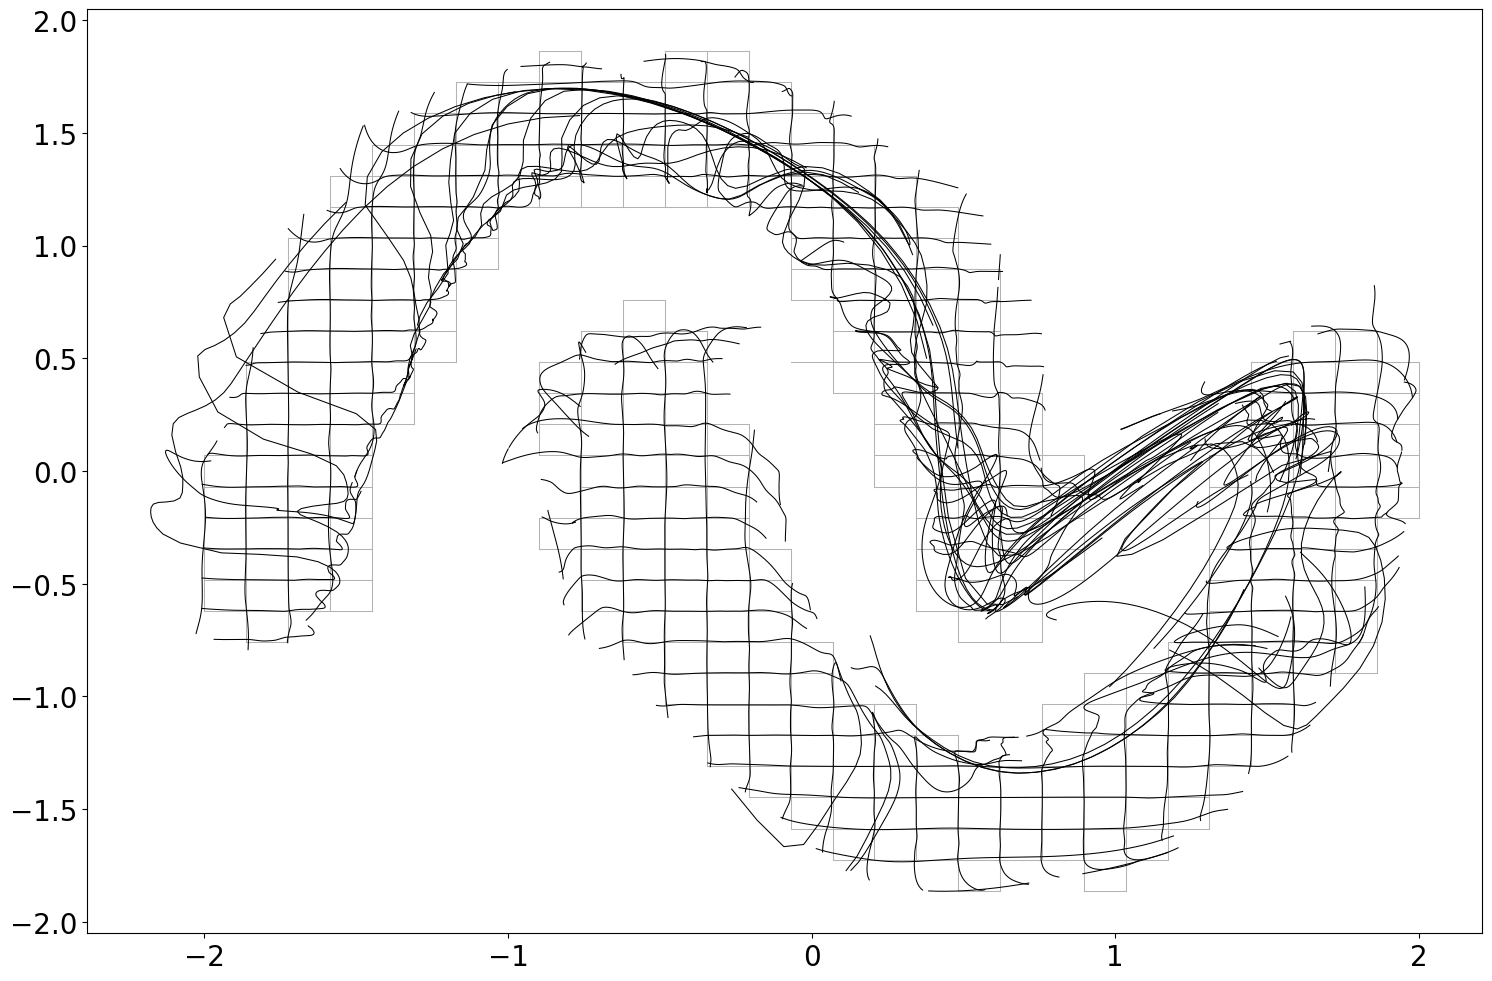

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(18, 12))

plot_samples_grid(axes, model)

In [24]:
def calc_PGD(x, c0, n_steps):
    torch.set_grad_enabled(True)
    c0 = torch.unsqueeze(c0,dim=0)
    x = x.to(model.device)
    
    def closs(c0, c_hat, x_hat):
        v = torch.sum(torch.sqrt(torch.sum(((c0 - c_hat)**2), dim=-1)))
        #distance = torch.sqrt(torch.sum(((x_hat.detach().cpu() - vx[0])**2), dim=-1))
        #r = torch.max(torch.Tensor([0., (distance - constraint).item()]))
        #print("loss:", v.item())
        #if r != 0:
        #    print("penalty:", r.item())
        return v
    
    class XModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.param = torch.nn.Parameter(x.clone())
    
    xmodel = XModel()
    optimizer = torch.optim.Adam(xmodel.parameters(), lr=0.005)
    max_x = torch.max(torch.abs(xmodel.param))
    
    c_empty = torch.empty((0,), device=model.device, dtype=x.dtype)
    for i in range(n_steps):
        conditioned = GT.apply_conditions((xmodel.param.to(model.device),))
        c_GT = conditioned.condition
        x_GT = conditioned.x0
        xc = (GT.encode(x_GT, c_GT).cpu() - model.data_shift) / model.data_scale
        loss = closs(c0, xc, x)
        """
        if loss < 1:
            for g in optimizer.param_groups:
                g['lr'] = 0.001
        """
        loss.backward()
        optimizer.step()
        # check, if image gets further apart than 
        #check = torch.mean(torch.sqrt(torch.sum(((x0 - zx.cpu())**2), dim=-1)))
        #if check > constraint:
        #    print("too far:")
        #    print(check.item())
        optimizer.zero_grad()
        if (loss<0.01 or math.isnan(loss)):
            break

    
    
    torch.set_grad_enabled(False)
    max_x_after = torch.max(torch.abs(xmodel.param))
    if max_x_after > 5. and (max_x_after-max_x) > 1.:
        print("warning!, z got an extreme value:", max_x_after)
    #zx = model.decode(xmodel.param.to(model.device), c_empty).detach().cpu()
    x = xmodel.param.detach().cpu()
    print(loss.item())
    return x, loss

In [15]:
c = c_targets[2].squeeze()
print(torch.min(c).item())
print(torch.max(c).item())

TypeError: 'NoneType' object is not subscriptable

In [14]:
from fff.evaluate.plots import all_conditions
def plot_cond_manifold(rectangular_flow):
    eps = 1e-12
    plt.figure(figsize=[18,12])

    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    val_samples = conditioned.x_noisy
    c = conditioned.condition

    device = rectangular_flow.device
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c.split(batch_size))
    ])
    print("decoding...")
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c.split(batch_size))
    ])
    z_test = torch.randn_like(z_train)
    print("decoding...")
    x1_test = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c.split(batch_size))
    ])
    print(x1_test.shape)

    plt.scatter(*val_samples.T, s=1, label="Original")
    plt.scatter(*x1_train.T, s=1, label="Reconstruction")
    plt.scatter(*x1_test.T, s=1, label="Samples")
    fibres, conditions = sample_fibres(rectangular_flow)
    print(fibres.shape)

    c_targets = []

    for i in range(conditions.shape[0]):
        r = 0.0005
        x1 = torch.Tensor([0])
        while x1.shape[0]<20 and r<0.01:
            mask1 = np.squeeze(c_train>conditions[i]-r)
            mask2 = np.squeeze(c_train<conditions[i]+r)
            mask = torch.logical_and(mask1, mask2)
            c_target=c_train[mask]
            x1 = train_samples[mask]
            r = r*1.1
            
        print(x1.shape[0])
        c_targets.append(c_target)
        plt.scatter(
                            x1[:,0],
                            x1[:,1],
                            s = 2,
                            c = "black",
                        )
    plt.scatter(
                [100],
                [100],
                s = 1,
                c = "black",
                label = "OrigFib",
                )

    plt.scatter(*fibres.T, s=1, c='red', label="Fibres")

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend(markerscale=5.)
    plt.savefig("fib_2m_small")
    plt.show()
    plt.close()

    plt.hist(*z_train.T, bins=60, label="Samples")
    plt.show()

    return c_targets

In [5]:
def sample_fibres(model, sub_resolution=100):
    samples = []
    pos_min, pos_max = -2.0, 2.0
    resolution = 50
    conditions = torch.linspace(pos_min, pos_max, resolution, device=model.device)
    latents = torch.randn([sub_resolution,1], device=model.device)
    for c in conditions:
        cond = c.repeat(latents.shape[0],1)
        samples.append(model.decode(latents, cond))
    x = torch.cat(samples, dim=0)
    return x.cpu().detach(), conditions.cpu().numpy()

In [56]:
plot_latent_codes_2d_1d(model)

NameError: name 'plot_latent_codes_2d_1d' is not defined

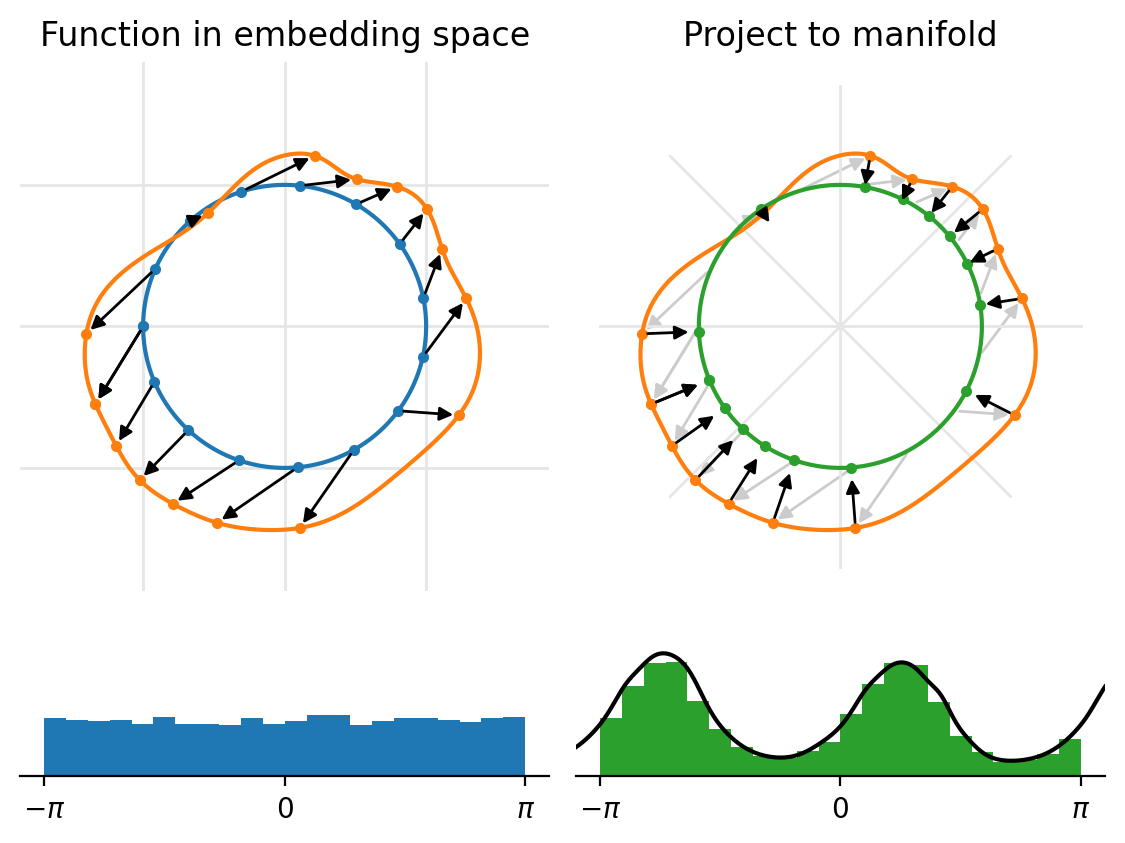

In [5]:
def euc_to_pol(x, distort=False):
    out = torch.stack([
        torch.atan2(x[:, 1], x[:, 0]),
        x.norm(2, -1)
    ], 1)
    if distort:
        # Exagerate deviations from circle
        out[:, 1] = (out[:, 1] - 1) * 3 + 1.3
    return out


def pol_to_euc(x):
    return x[:, 1:] * torch.stack([
        torch.cos(x[:, 0]),
        torch.sin(x[:, 0])
    ], 1)


fig, axes = plt.subplots(2, 2, sharex="row", sharey="row", figsize=(7, 5),
                         gridspec_kw=dict(height_ratios=[1, .2]))

# Generation process from equally spaced points in latent space
thetas_fine = torch.linspace(-torch.pi, torch.pi, 360)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
x1_fine = model.decode(batch.x0, batch.condition, project=False)
x1_proj_fine = model.manifold.projection(x1_fine)
x1_distorted_fine = pol_to_euc(euc_to_pol(x1_fine, True))
pol1_proj_fine = euc_to_pol(x1_proj_fine)

# Neural network acts in embedding
plt.sca(axes[0, 0])
plt.plot(*z_fine.T, label="Input data")
plt.plot(*x1_distorted_fine.T, label="Raw output")
subset = torch.linspace(0, len(thetas_fine) - 1, 16).long()
ms = 3
plt.plot(*z_fine[subset].T, "C0o", label="Selected raw output", ms=ms)
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
for x_in, x_out in zip(z_fine[subset], x1_distorted_fine[subset]):
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
plt.axis("off")
plt.title("Function in embedding space")
axes[0, 0].set_aspect(1)
for pos in [-1, 0, 1]:
    plt.axhline(pos, c=".9", zorder=-1, lw=1)
    plt.axvline(pos, c=".9", zorder=-1, lw=1)


# Projection to circle
plt.sca(axes[0, 1])
plt.title("Project to manifold")
plt.plot(*x1_distorted_fine.T, "C1", label="Raw output")
plt.plot(*x1_proj_fine.T, "C2", label="Projected output")
plt.plot(*x1_distorted_fine[subset].T, "C1o", label="Selected raw output", ms=ms)
plt.plot(*x1_proj_fine[subset].T, "C2o", label="Selected raw output", ms=ms)
for x0, x_in, x_out in zip(
    z_fine[subset], x1_distorted_fine[subset], x1_fine[subset]
):
    plt.annotate("", x_in, x0, arrowprops=dict(
        arrowstyle='-|>', fc=".8", ec=".8"
    ), zorder=-1)
    plt.annotate("", x_out, x_in, arrowprops=dict(
        arrowstyle='-|>', fc="k",
    ))
# Hint at polar projection using fake grid
for theta in torch.linspace(0, 2 * torch.pi, 8 + 1)[:-1]:
    plt.plot([0, 1.7 * np.cos(theta)], [0, 1.7 * np.sin(theta)], c=".9", zorder=-1, lw=1)

plt.axis("off")
axes[0, 1].set_aspect(1)

# Lower plots: Show histograms
count = 10_000
for ax, samples, color in zip(axes[1], [
    model.get_latent("cpu").sample((count,)),
    model.sample((count,)),
], ["C0", "C2"]):
    plt.sca(ax)
    ax.spines[["left", "top", "right"]].set_visible(False)
    plt.hist(euc_to_pol(samples)[:, 0], "auto", density=True, fc=color)
    plt.yticks([])
    plt.xticks([-np.pi, 0, np.pi], ["$-\\pi$", "$0$", "$\\pi$"])
    plt.xlim(-1.1 * np.pi, 1.1 * np.pi)

# Show density in lower left plot
plt.sca(axes[1, 1])
thetas_fine = torch.linspace(-1.1 * torch.pi, 1.1 * torch.pi, 300)
z_fine = torch.stack([
    torch.cos(thetas_fine),
    torch.sin(thetas_fine)
], 1)
batch = model.apply_conditions([z_fine])
probs = model.exact_log_prob(batch.x0, batch.condition).log_prob.exp()
plt.plot(thetas_fine, probs, "k")

# Adjust spacing
plt.subplots_adjust(wspace=.05, hspace=0)
# plt.savefig("m-fff-projection.pdf", bbox_inches="tight")

In [ ]:
train_data = GT.train_data[:]
    val_data = GT.val_data[:]
    test_data = GT.test_data[:]

    conditioned = GT.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = GT.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = GT.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    print("encoding traindata...")
    batch_size = GT.hparams.batch_size
    z_train = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        GT.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])
    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()